In [63]:
# necessary import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [64]:

class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
        
    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)
        
        # Вычисляем средние значения для каждого класса
        mean_overall = np.mean(X, axis=0)
        mean_class = {}
        for label in class_labels:
            mean_class[label] = np.mean(X[y==label], axis=0)
        
        # Вычисляем матрицу разброса между классами и внутри классов
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        for label in mean_class.keys():
            n = X[y==label].shape[0]
            diff = (X[y==label] - mean_class[label])
            S_W += np.dot(diff.T, diff) / n
            mean_diff = (mean_class[label] - mean_overall).reshape(n_features, 1)
            S_B += n * np.dot(mean_diff, mean_diff.T)
        
        # Вычисляем собственные значения и собственные векторы для inv(S_W) dot S_B
        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
        
        # Сортируем собственные значения и соответствующие им собственные векторы
        eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
        eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
        
        # Сохраняем топ-компоненты
        self.linear_discriminants = np.array([eigen_pairs[i][1] for i in range(self.n_components)])
        
    def transform(self, X):
        return np.dot(X, self.linear_discriminants.T)

In [65]:
# load the iris dataset
iris = load_iris()
dataset = pd.DataFrame(columns=iris.feature_names,
                       data=iris.data)
dataset['target'] = iris.target

In [66]:
# divide the dataset into class and target variable
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values

In [67]:
# Preprocess the dataset and divide into train and test
sc = StandardScaler()
X = sc.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.2)

In [68]:
# Создаем объект LDA с заданным количеством компонентов
lda = LDA(n_components=2)

# Обучаем модель на обучающих данных
lda.fit(X_train, y_train)

# Преобразуем данные с помощью LDA
X_train = lda.transform(X_train)
X_test = lda.transform(X_test)

Accuracy : 0.9666666666666667
[[ 8  0  0]
 [ 0 10  1]
 [ 0  0 11]]


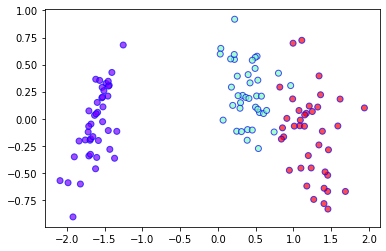

In [69]:
# plot the scatterplot
plt.scatter(
    X_train[:, 0], X_train[:, 1],
    c=y_train,
    cmap='rainbow',
    alpha=0.7, edgecolors='b'
)

# classify using random forest classifier
classifier = RandomForestClassifier(max_depth=2,
                                    random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# print the accuracy and confusion matrix
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)